*Page and Latex Commands*
$\newcommand{\CC}{\mathbb{C}}
\renewcommand{\RR}{\mathbb{R}}
\renewcommand{\ZZ}{\mathbb{Z}}
\renewcommand{\NN}{\mathbb{N}}
\newcommand{\QQ}{\mathbb{Q}}
\newcommand{\mP}{\mathcal{P}}
\newcommand{\bp}{\begin{pmatrix}}
\newcommand{\ep}{\end{pmatrix}}
$

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sys

# Settings
plt.style.use('classic')
sys.path.append('.././')

from lib.findiff import *
#from lib.opt import *
from lib.krot import *

# Kantorovich-Rubenstein OT

**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \RR^+$ find the function which minimizes the following integral equation

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$


**In One Dimension**

The problem may be formulated as the following if $X$ is a one dimensional space.

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & -|\nabla c(x)| \leq \nabla \phi(x)\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$
                
*Discretized Problem*

We discretized the problem for some points $x_i$ so that the mass at any location is given by $\rho(x_i)=\rho_i$, and the mass to be contained is given by $\sigma(y_i)=\sigma_i$. Let $d_i=|\nabla c(x_i)|$ and the discrete approximation of $\nabla$ is given by $D_1$.

Then we seek to find $\phi(x_i)=\phi_i$ satisfying the following optimization problem. This is a linear programming problem.

$$\begin{align*} \min_\phi \quad & \sum_{i=1}^N \phi_i(\rho_i-\sigma_i) \\
                \text{s.t.}\quad & -d_i \leq D_+\phi_i \leq d_i,\quad \forall i=\{1,...,N\} \end{align*}$$

### Example 1

In [2]:
 #GRID
n = 20*6; h=1/(n-1)
x = np.linspace(0,1,n)
#DISTRIBUTIONS
rho= np.zeros(n); rho[n//10] = 1 
sigma = np.zeros(n); sigma[9*n // 10] = 1
#FUNCTIONS
Gc = np.ones(n)
phi = cp.Variable(n)
#OPERATORS
Nabla = D1FE(n, bc = 'Neumann', matrix=True)/h

The inequality LP problem is equivalent
$$\begin{align*} \min_x \quad & c^Tx \\
                \text{s.t.}\quad & Ax\leq b \end{align*}$$
where
- $c=\rho-\sigma$
- $x=\phi$
- $A=\nabla$
- $b=\pm d$.

In [3]:
#LP PROBLEM
A=Nabla
c = rho-sigma
b=Gc
#SOLVE
prob = cp.Problem(cp.Minimize(c.T@phi), [A@phi<=b,-A@phi<=b])
prob.solve()

-0.8067226889051241

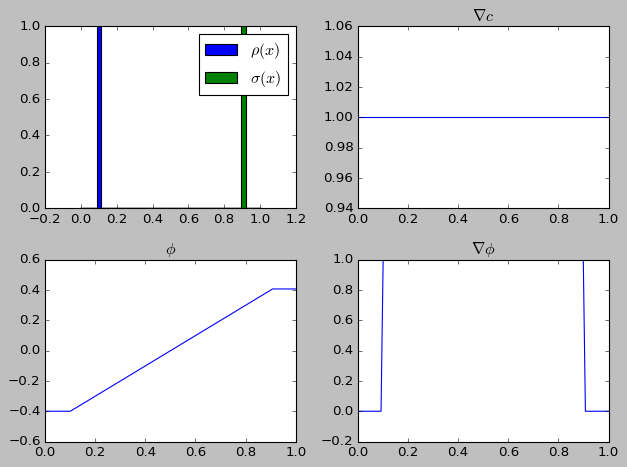

In [4]:
plt.figure(tight_layout=True)
plt.subplot(221)
plt.bar(x,rho, width = 3*h, label='$\\rho(x)$')
plt.bar(x,sigma, width = 3*h, label='$\\sigma(x)$')
plt.legend()
plt.subplot(222)
plt.plot(x,Gc)
plt.title("$\\nabla c$")
plt.subplot(223)
plt.plot(x,phi.value)
plt.title("$\phi$")
plt.subplot(224)
plt.plot(x,A@phi.value)
plt.title("$\\nabla \phi$")
plt.show()

### Example 2

In [5]:
 #GRID
n = 20*6; h=1/(n-1)
x = np.linspace(0,1,n)
#DISTRIBUTIONS
rho,rho[n//2]=np.zeros(n),3
sigma,sigma[1],sigma[n-2] = np.zeros(n),1,2
#FUNCTIONS
Gc = np.ones(n)
Gc[n//4:3*n//4]=2*np.ones(3*n//4-n//4)
#SOLVE
prob = lin_krot(x,rho-sigma, Gc)
phi=prob._solve()

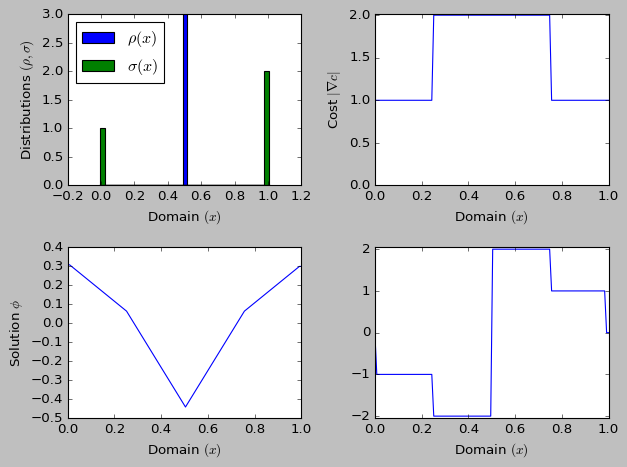

In [6]:
plt.figure(tight_layout=True)
plt.subplot(221)
plt.bar(x,rho, width = 3*h, label='$\\rho(x)$')
plt.bar(x,sigma, width = 3*h, label='$\\sigma(x)$')
plt.legend(loc=0)
plt.xlabel('Domain $(x)$')
plt.ylabel('Distributions $(\\rho,\\sigma)$')
plt.subplot(222)
plt.plot(x,Gc)
plt.xlabel('Domain $(x)$')
plt.ylabel('Cost $|\\nabla c|$')
plt.ylim([0,2.01])
plt.subplot(223)
plt.plot(x,phi)
plt.xlabel('Domain $(x)$')
plt.ylabel('Solution $\\phi$')
plt.subplot(224)
plt.plot(x,A@phi)
plt.ylim([-2.05,2.05])
plt.xlabel('Domain $(x)$')
plt.savefig('../lindist.pdf')
plt.show()

**Missing Information**

All of the transportation network information is contained in $\phi(x)$. The optimal network can be found by formulating the primal problem in terms of the dual problem.  However this reformulation requires knowledge of the distributed cost function $c(p,q)$. In the case that only features of the distributed cost function are known i.e. $\nabla c$, the dual step is missing information about the optimal network.

* How much mass is transferred along in the flow $\nabla \phi$?

* When has a particular mass reached its destination?

For example, were you to govern the flow of a set of objects using (3.1), your objects will transfer entirely to the final node.

*Note:* In the $\lambda$ problem changes in the masses or cost in the flow act are seen as impulses on the flow.

# Augmented Kantorovich-Rubenstein OT


**Problem Statement**

Provided initial mass distribution $\rho$ and final mass distribution $\sigma$ over a compact metric space $X$, along with the gradient of the cost function for each point in the space $\nabla c : x\in X \rightarrow \RR^+$ find the function which minimizes the following integral equation

$$\begin{align*} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) \\
                \text{s.t.}\quad & |\nabla \phi(x)|\leq |\nabla c(x)|,\quad \forall x\in X \end{align*}$$


*Lagrangian*

The Lagrangian is formed by taking $\lambda\in \RR^n_+$ to be the Lagrange multplier for the above constraing. The augmented Lagrangian is given by the following integral equation.

$$\begin{align} \min_\phi \quad & \int_X \phi(x)\left(\rho(x)-\sigma(x)\right) + \lambda(x)\left( |\nabla c(x)|-| \nabla \phi(x)|\right) \\
                \text{s.t.}\quad &\lambda(x)\left( |\nabla c(x)|-| \nabla \phi(x)|\right)=0 \quad \forall x\in X \end{align}$$
                
                                
*Euler Equations*

The Euler Equations for the above problem are given by the following variable coefficient elliptic PDE.

$$\begin{align} &\nabla \cdot \left( \frac{\lambda}{|\nabla \phi|}\nabla \phi \right) = \sigma-\rho \\
                \text{s.t.}\quad & \frac{\partial\phi}{\partial n}=0 \quad \forall x\in\partial X \end{align}$$

### Example 1 Revisited

In [7]:
 #GRID
n = 20*6; h=1/(n-1)
x = np.linspace(0,1,n)
#DISTRIBUTIONS
rho= np.zeros(n); rho[n//10] = 1 
sigma = np.zeros(n); sigma[9*n // 10] = 1
#FUNCTIONS
Gc = np.ones(n)
phi = cp.Variable(n)
#OPERATORS
Nabla = D1FE(n, bc = 'Neumann', matrix=True)/h

We solve this in two steps. First solve

$$\begin{align} &\nabla \cdot \psi = \sigma-\rho \\
                \text{s.t.}\quad & \frac{\partial\psi}{\partial n}=0 \quad \forall x\in\partial X \end{align}$$

In [8]:
#SETUP
f = sigma-rho
A = Nabla
psi = cp.Variable(n)
#SOLVE
prob = cp.Problem(cp.Minimize(cp.sum_squares(A.T@psi-f)))
prob.solve()

9.861125032820655e-31

Then solve

$$\begin{align} &\psi = \frac{\lambda}{|\nabla c|} \nabla \phi \\
                \text{s.t.}\quad & \frac{\partial\phi}{\partial n}=0 \quad \forall x\in\partial X \end{align}$$

In [9]:
Gphi = np.array([np.sign(np.round(psi.value[i],2))*Gc[i] for i in range(n)])
phi = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.sum_squares(A@phi-Gphi)))
prob.solve()

1.9209749118263164e-27

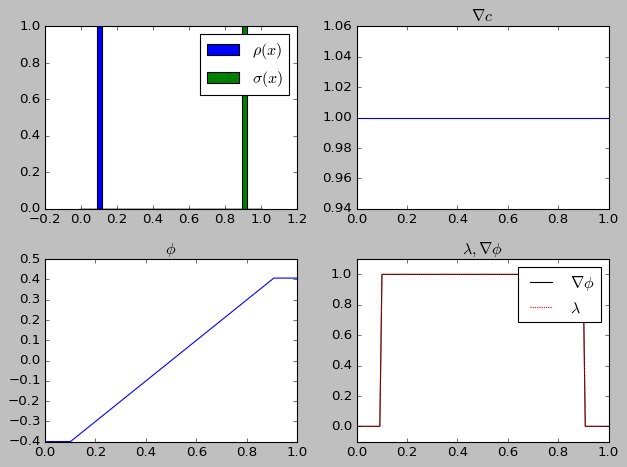

In [10]:
k = abs(psi.value)/h
plt.figure(tight_layout=True)
plt.tight_layout()
plt.subplot(221)
plt.bar(x,rho, width = 3*h, label='$\\rho(x)$')
plt.bar(x,sigma, width = 3*h, label='$\sigma(x)$')
plt.legend()
plt.subplot(222)
plt.plot(x,Gc)
plt.title("$\\nabla c$")
plt.subplot(223)
plt.plot(x,phi.value)
plt.title("$\phi$")
plt.subplot(224)
plt.plot(x,A@phi.value, label="$\\nabla \phi$", color='k')
plt.plot(x,k,label="$\\lambda$", color='r', dashes=(1,1))
plt.title("$\\lambda, \\nabla \phi$")
plt.ylim(-.1,1.1)
plt.legend()
plt.show()

### Example 2 Revisited

In [11]:
 #GRID
n = 20*6; h=1/(n-1)
x = np.linspace(0,1,n)
#DISTRIBUTIONS
rho,rho[n//2]=np.zeros(n),3
sigma,sigma[1],sigma[n-2] = np.zeros(n),1,2
#FUNCTIONS
Gc = np.ones(n)
Gc[n//4:3*n//4]=2*np.ones(3*n//4-n//4)
#SOLVE
prob = aug_krot(x,sigma-rho, Gc)
phi,k= prob._solve()

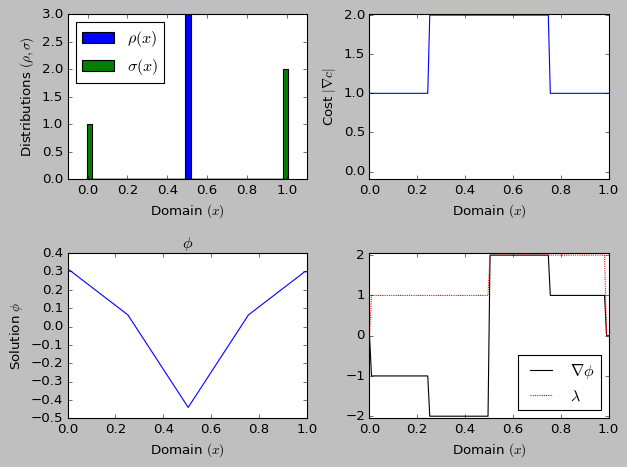

In [12]:
plt.figure(tight_layout=True)
plt.tight_layout()
plt.subplot(221)
plt.bar(x,rho, width = 3*h, label='$\\rho(x)$')
plt.bar(x,sigma, width = 3*h, label='$\sigma(x)$')
plt.legend(loc=0)
plt.ylim(0,3)
plt.xlim(-.1,1.1)
plt.xlabel('Domain $(x)$')
plt.ylabel('Distributions $(\\rho,\\sigma)$')
plt.subplot(222)
plt.plot(x,Gc)
plt.ylim(-.1,2.01)
plt.xlabel('Domain $(x)$')
plt.ylabel('Cost $|\\nabla c|$')
plt.subplot(223)
plt.plot(x,phi)
plt.title("$\phi$")
plt.xlabel('Domain $(x)$')
plt.ylabel('Solution $\\phi$')
plt.subplot(224)
plt.plot(x,A@phi, label="$\\nabla \phi$", color='k')
plt.plot(x,k,label="$\\lambda$", color='r', dashes=(1,1))
plt.ylim(-2.05,2.05)
plt.xlabel('Domain $(x)$')
plt.legend(loc=0)
plt.savefig('../graddist.pdf')
plt.show()

# Two Dimensions

In two dimensions the constraint becomes much more challenging.